# New Import

In [ ]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Read Kaggle data

df_sales = pd.read_csv("train.csv")
df_stores = pd.read_csv("store.csv")
df_sales["Date"] = pd.to_datetime(df_sales["Date"])

# For simplicity, the treatment set will be a set of stores which all had nearby competition open at the same time
# And the control set will be the stores with no competition
df_stores_treat = df_stores[
                    (df_stores["CompetitionOpenSinceYear"] == 2013)&
                    (df_stores["CompetitionOpenSinceMonth"] == 4)&
                    (df_stores["CompetitionDistance"] < 1000)
                    ]

#df_stores_control = df_stores[df_stores["CompetitionOpenSinceYear"].isnull()].sample(int(len(df_stores_treat)), random_state = 40)   #Take sample to prevent control group being huge compared to treatment
df_stores_control = df_stores[df_stores["CompetitionOpenSinceYear"].isnull()].sample(
    n=min(int(len(df_stores_treat)), int(0.1 * len(df_stores))),
    random_state=40
)  # Take sample limited to 10% of total file size




df_sales_treat = df_sales[df_sales["Store"].isin(df_stores_treat["Store"])]
df_sales_control = df_sales[df_sales["Store"].isin(df_stores_control["Store"])]

df_sales_treat["Group"] = 'Treat'
df_sales_control["Group"] = 'Control'

C:\Users\yuriy\AppData\Local\Temp\ipykernel_27868\1528721981.py:10: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query("Group == 'Treat' and Year==2013 and Date.dt.month==4")


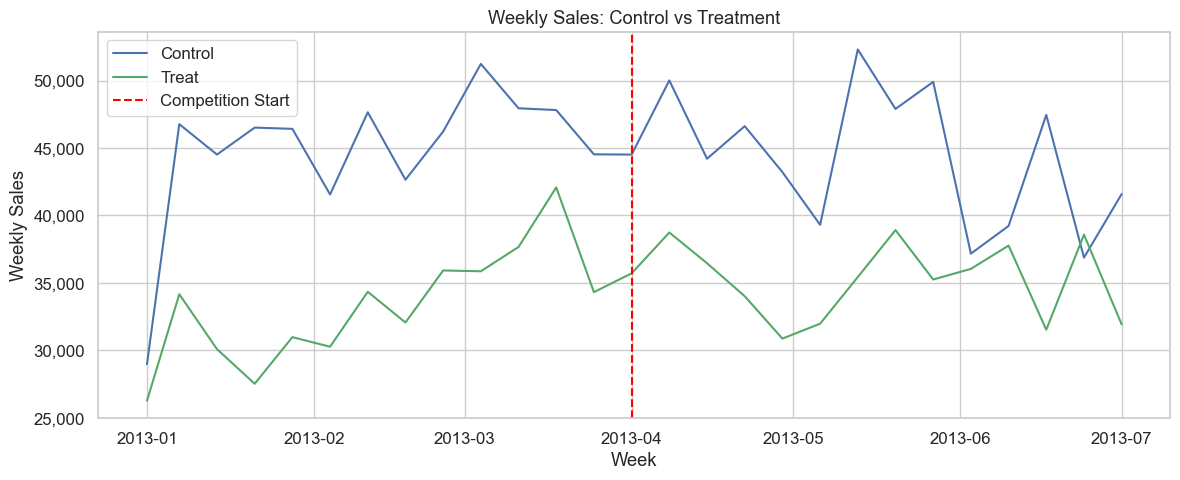

In [29]:
# Aggregate sales by week
df_sales_combined = pd.concat([df_sales_treat, df_sales_control])
df_sales_combined["Year"] = df_sales_combined["Date"].dt.isocalendar().year
df_sales_combined["Week"] = df_sales_combined["Date"].dt.isocalendar().week
df_weekly_sales = df_sales_combined.groupby(["Group", "Year", "Week"]).agg({'Sales':'sum', 'Date':'first'}).reset_index()

# Identify when competition started
comp_start = (
    df_weekly_sales
      .query("Group == 'Treat' and Year==2013 and Date.dt.month==4")
      .Date
      .min()
)

# Cut data to 3months on each side
start_date = comp_start - DateOffset(months=3)
end_date   = comp_start + DateOffset(months=3)

df_weekly_sales = df_weekly_sales[
    (df_weekly_sales.Date >= start_date) &
    (df_weekly_sales.Date <= end_date)
]



# Plot sales
sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=df_weekly_sales,
    x='Date',
    y='Sales',
    hue='Group',
    palette=['#4C72B0','#55A868'],
    linewidth=1.5
)

ax.yaxis.set_major_formatter(
    ticker.StrMethodFormatter('{x:,.0f}')
)

plt.axvline(comp_start, color="red", linestyle="--", label="Competition Start")
plt.legend()

plt.title('Weekly Sales: Control vs Treatment')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.legend(title='')
plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import pandas as pd

# Ensure datatypes
df = df_sales_combined.copy()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
comp_start = pd.to_datetime(comp_start, errors='coerce')
if pd.isna(comp_start):
    raise ValueError("comp_start is not a valid date. Set comp_start to a parsable date string or Timestamp.")

# Normalize group names and keep only the two groups
df['Group'] = df['Group'].astype(str).str.strip().str.title()
df = df[df['Group'].isin(['Treat', 'Control'])]

# Indicators
df['Post'] = (df['Date'] >= comp_start).astype('Int64')

# Optional: ISO year-week (avoids apply)
iso = df['Date'].dt.isocalendar()
df['Year'] = iso.year.astype('Int64')
df['Week'] = iso.week.astype('Int64')
df['Year_week'] = df['Year'].astype(str) + '-' + df['Week'].astype(str).str.zfill(2)

# Aggregate means and force full 2x2 grid
df_did = (
    df.groupby(['Group', 'Post'], as_index=False)['Sales']
      .mean()
)
df_did
# Pivot with explicit reindex to ensure rows/cols exist
pvt = (
    df_did.pivot_table(index='Group', columns='Post', values='Sales', aggfunc='mean')
         .reindex(index=['Treat', 'Control'])
         .reindex(columns=[0, 1], fill_value=np.nan)
)
pvt
# Guard against missing cells
for grp in ['Treat', 'Control']:
    if grp not in pvt.index:
        raise ValueError(f"Missing group '{grp}' in data after filtering.")
for col in [0, 1]:
    if col not in pvt.columns or pvt[col].isna().any():
        raise ValueError("Missing pre/post observations for at least one group.")
pvt
# # Compute DiD
# treat_change   = pvt.loc['Treat', 1] - pvt.loc['Treat', 0]
# control_change = pvt.loc['Control',   1] - pvt.loc['Control',   0]
# did = (treat_change - control_change)
# did

Post,0,1
Group,,
Treat,4794.777778,5009.446009
Control,6475.266667,6514.234742


In [4]:
# Compute DiD
treat_change   = pvt.loc['Treat', 1] - pvt.loc['Treat', 0]
control_change = pvt.loc['Control',   1] - pvt.loc['Control',   0]
did = (treat_change - control_change)
did

np.float64(175.70015649452307)

In [5]:
# Ensure columns for DiD regression
df = df.dropna(subset=['Sales', 'Post']).copy()
df['Post'] = df['Post'].astype(int)
df['Treat'] = (df['Group'] == 'Treat').astype(int)

import statsmodels.formula.api as smf
# DiD with interaction
model = smf.ols('Sales ~ Treat + Post + Treat:Post', data=df).fit()
display(model.summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6475.2667,278.060,23.287,0.000,5929.928,7020.605
Treat,-1680.4889,393.236,-4.273,0.000,-2451.714,-909.264
Post,38.9681,292.377,0.133,0.894,-534.450,612.387
Treat:Post,175.7002,413.484,0.425,0.671,-635.236,986.636


In [6]:
model_cr = smf.ols('Sales ~ Treat * Post', data=df).fit(cov_type='cluster', cov_kwds={'groups': df['Store']})
display(model_cr.summary().tables[1])

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,6475.2667,9.05e-11,7.15e+13,0.000,6475.267,6475.267
Treat,-1680.4889,1.94e-10,-8.68e+12,0.000,-1680.489,-1680.489
Post,38.9681,5.87e-11,6.64e+11,0.000,38.968,38.968
Treat:Post,175.7002,6.85e-11,2.56e+12,0.000,175.700,175.700


In [ ]:
# DiD with fixed effects
model = smf.ols('Sales ~ Treat*Post + C(Store) + C(Year_week)', data=df).fit(
    cov_type='cluster', cov_kwds={'groups': df['Store']}
)
display(model.summary().tables[1])

# Define Model 

In [30]:
import pymc as pm
import arviz as az

# Index stores and weeks
df['store_idx'] = df['Store'].astype('category').cat.codes
df['week_idx']  = df['Year_week'].astype('category').cat.codes

store_idx = df['store_idx'].to_numpy(dtype=np.int64)   # indexers MUST be int64
week_idx  = df['week_idx'].to_numpy(dtype=np.int64)    # indexers MUST be int64
treat     = df['Treat'].to_numpy(dtype=np.int64)       # binary/indicator ok as int64
post      = df['Post'].to_numpy(dtype=np.int64)        # binary/indicator ok as int64
sales     = df['Sales'].to_numpy(dtype=np.float64)     # likelihood is float64

n_store = int(df['store_idx'].nunique())
n_week  = int(df['week_idx'].nunique())


sales_mean = sales.mean()
sales_std  = sales.std()
sales_stdized = (sales - sales_mean) / sales_std

with pm.Model() as did_bayes:
  # Random intercept SDs
  sigma_store = pm.HalfNormal("sigma_store", sigma=1000.0)
  sigma_week  = pm.HalfNormal("sigma_week",  sigma=1000.0)
  sigma_res   = pm.HalfNormal("sigma_res",   sigma=1000.0)

  # Random intercepts
  intercept_store = pm.Normal("intercept_store", mu=0, sigma=sigma_store, shape=n_store)
  intercept_week  = pm.Normal("intercept_week",  mu=0, sigma=sigma_week,  shape=n_week)

  # Global intercept and DiD coefficients
  alpha          = pm.Normal("alpha", mu=0, sigma=1000.0)
  beta_treat     = pm.Normal("beta_treat", mu=0, sigma=1000.0)
  beta_post      = pm.Normal("beta_post",  mu=0, sigma=1000.0)
  beta_treatpost = pm.Normal("beta_treatpost", mu=0, sigma=1000.0)  # DiD effect

  mu_std = (
      alpha
      + intercept_store[store_idx]
      + intercept_week[week_idx]
      + beta_treat * treat
      + beta_post  * post
      + beta_treatpost * (treat * post)
  )

  pm.Normal("y_obs", mu=mu_std, sigma=sigma_res, observed=sales_stdized)



In [ ]:
with did_bayes:
    trace = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        cores=4,    
        target_accept=0.95,
        random_seed=42,
        return_inferencedata=True
    )

az.summary(
    trace,
    var_names=['beta_treatpost','sigma_store','sigma_week','sigma_res'],
    round_to=2
)